In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from xgboost import XGBRegressor
import joblib
import glob
import os
import time
from prophet import Prophet

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#configuracion
plt.style.use("ggplot")

#carga de datos
path = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
all_files = glob.glob(os.path.join(path, "df*.csv"))

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    if 'fecha_de_apertura' in df.columns:
        df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

/tmp/ipykernel_301891/2240019547.py:12: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)


Días analizados: 1096


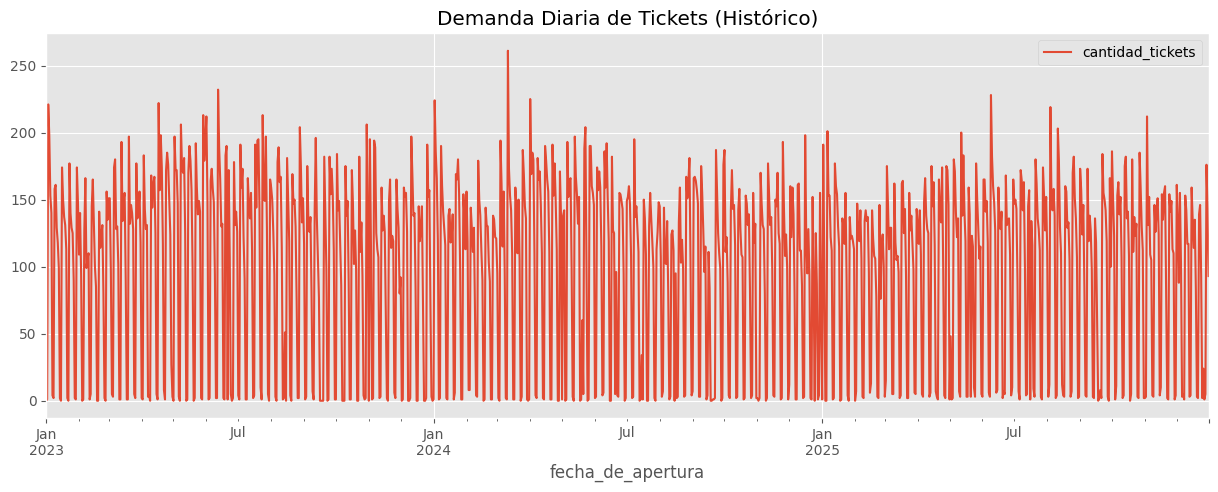

In [3]:
#agrupacion diaria y conteo de tickets
df_all = df_all.set_index("fecha_de_apertura").sort_index()
ts_diaria = df_all.resample("D")["id"].count().to_frame(name="cantidad_tickets")

#filtramos por año
ts_diaria = ts_diaria[(ts_diaria.index.year >= 2023) & (ts_diaria.index.year < 2026)]

print(f"Días analizados: {len(ts_diaria)}")
ts_diaria.plot(figsize=(15, 5), title='Demanda Diaria de Tickets (Histórico)')
plt.show()

In [4]:
#feature engineering
def crear_features(df, target_col='cantidad_tickets'):
    df = df.copy()
    
    df['lag_1'] = df[target_col].shift(1)
    df['lag_7'] = df[target_col].shift(7)
    df['rolling_mean_7'] = df[target_col].shift(1).rolling(window=7).mean()
    df['dia_semana'] = df.index.dayofweek
    
    
    df['es_cierre_mes'] = df.index.is_month_end | (df.index.day >= df.index.days_in_month - 1)
    
    feriados_str = ['01-01', '05-01', '21-05', '18-09', '19-09', '01-11', '08-12', '25-12']
    df['fecha_str'] = df.index.strftime('%d-%m')
    df['es_feriado'] = df['fecha_str'].isin(feriados_str)
    
    
    df = df.drop(columns=['fecha_str']).dropna()
    
    cols_bool = ['es_cierre_mes', 'es_feriado']
    df[cols_bool] = df[cols_bool].astype(int)
    
    return df

df_features= crear_features(ts_diaria)
print("Ejemplo de datos para el modelo:")
display(df_features.head())

print("Nuevas variables creadas:")
print(df_features.columns.tolist())

Ejemplo de datos para el modelo:


,cantidad_tickets,lag_1,lag_7,rolling_mean_7,dia_semana,es_cierre_mes,es_feriado
fecha_de_apertura,,,,,,,
2023-01-08,2,4.0,0.0,102.428571,6,0,0
2023-01-09,158,2.0,1.0,102.714286,0,0,0
2023-01-10,161,158.0,221.0,125.142857,1,0,0
2023-01-11,129,161.0,198.0,116.571429,2,0,0
2023-01-12,118,129.0,153.0,106.714286,3,0,0


Nuevas variables creadas:
['cantidad_tickets', 'lag_1', 'lag_7', 'rolling_mean_7', 'dia_semana', 'es_cierre_mes', 'es_feriado']


# Prueba de training y evaluacion con Randon Forest

Resultados del Modelo
Error Promedio Absoluto (MAE): 17.1 tickets
Interpretación: El modelo se equivoca en +/- 17.1 tickets por día.


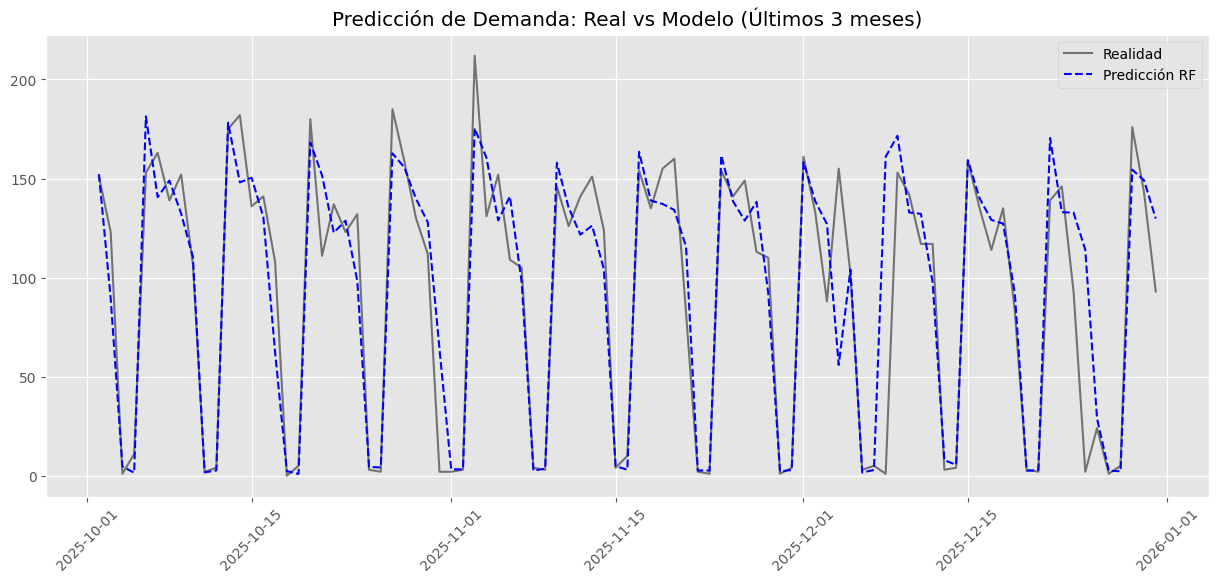

In [5]:
#trainning y eval

#ultimos 3 meses para eval
fecha_corte = df_features.index.max() - pd.Timedelta(days=90)

#sets
train = df_features[df_features.index < fecha_corte]
test = df_features[df_features.index >= fecha_corte]

features = ['dia_semana', 
            'lag_1', 'lag_7', 'rolling_mean_7']
target = 'cantidad_tickets'

#definiciones
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

#Modelo Random Forest
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X_train, y_train)

#prediccion
predicciones = model.predict(X_test)

#evaluacion
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

#visualizar
print(f"Resultados del Modelo")
print(f"Error Promedio Absoluto (MAE): {mae:.1f} tickets")
print(f"Interpretación: El modelo se equivoca en +/- {mae:.1f} tickets por día.")

# 5. Visualizar Real vs Predicho
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Realidad', color='black', alpha=0.5)
plt.plot(test.index, predicciones, label='Predicción RF', color='blue', linestyle='--')
plt.title(f'Predicción de Demanda: Real vs Modelo (Últimos 3 meses)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [6]:
#guardar modelo
os.makedirs('../models', exist_ok=True)
joblib.dump(model, '../models/predictor_demandaRF_v1.pkl')
print("Modelo guardado exitosamente en models/predictor_demanda_v1.pkl")

Modelo guardado exitosamente en models/predictor_demanda_v1.pkl


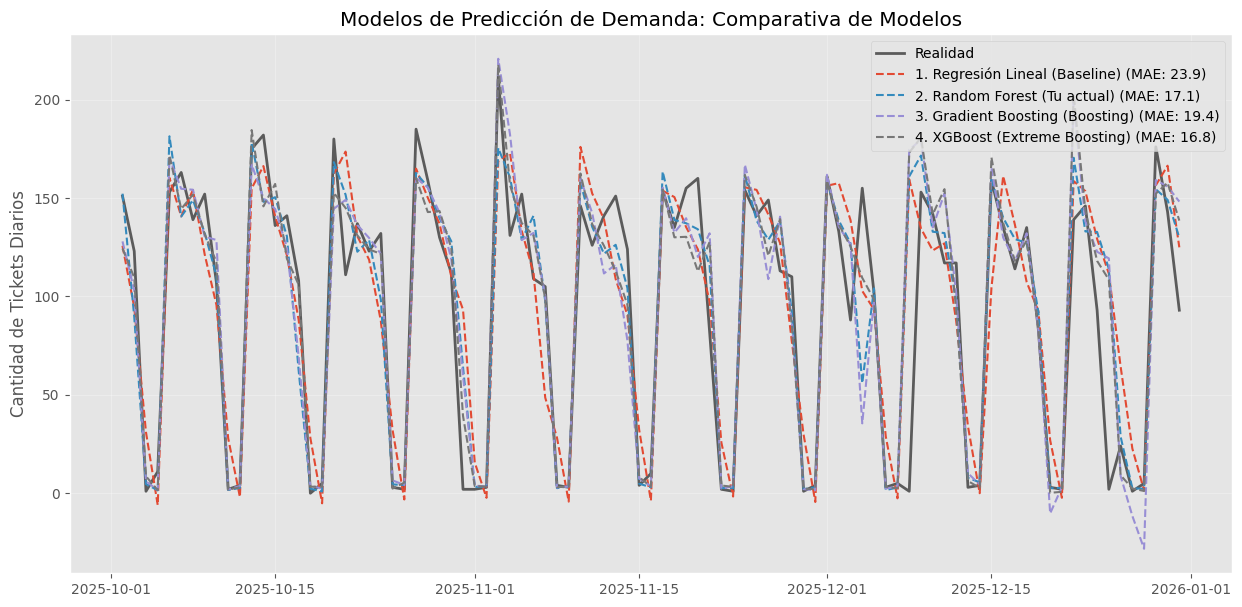


Mejores modelos (Menor MAE gana) 
                            Modelo        MAE       RMSE
3    4. XGBoost (Extreme Boosting)  16.849911  28.930872
1     2. Random Forest (Tu actual)  17.062732  29.509185
2  3. Gradient Boosting (Boosting)  19.428227  33.183331
0   1. Regresión Lineal (Baseline)  23.875432  33.175403


In [7]:
#modelos a probar
modelos = {
    "1. Regresión Lineal (Baseline)": LinearRegression(),
    "2. Random Forest (Tu actual)": RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42),
    "3. Gradient Boosting (Boosting)": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42),
    "4. XGBoost (Extreme Boosting)": XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=-1, random_state=42)
}

#training y eval
resultados = []
predicciones_dict = {}

plt.figure(figsize=(15, 7))
plt.plot(test.index, y_test, label='Realidad', color='black', linewidth=2, alpha=0.6)

for nombre, modelo in modelos.items():
    #train
    modelo.fit(X_train, y_train)
    preds = modelo.predict(X_test)
    predicciones_dict[nombre] = preds

    #eval
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    #guardar y plot
    resultados.append({'Modelo': nombre, 'MAE': mae, 'RMSE': rmse})
    plt.plot(test.index, preds, label=f'{nombre} (MAE: {mae:.1f})', linestyle='--')

plt.title('Modelos de Predicción de Demanda: Comparativa de Modelos')
plt.ylabel('Cantidad de Tickets Diarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#posiciones
df_resultados = pd.DataFrame(resultados).sort_values('MAE')
print("\nMejores modelos (Menor MAE gana) ")
print(df_resultados)



In [8]:
#guardar mejor modelo
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
mejor_mae = df_resultados.iloc[0]['MAE']
print(f"\n Guardando el ganador: {mejor_modelo_nombre}")

modelo_ganador = modelos[mejor_modelo_nombre]
joblib.dump(modelo_ganador, '../models/mejor_predictor_demanda.pkl')


 Guardando el ganador: 4. XGBoost (Extreme Boosting)


['../models/mejor_predictor_demanda.pkl']

Iniciando optimización con 998 registros de entrenamiento...

Optimizando Random Forest
Fitting 3 folds for each of 135 candidates, totalling 405 fits


<>:54: SyntaxWarning: invalid escape sequence '\ '
<>:54: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_301891/1836031135.py:54: SyntaxWarning: invalid escape sequence '\ '
  print("\ Optimizando XGBoost")


Mejor RF encontrado en 97.1s
MAE Promedio en Validación: 17.87
Mejores Parámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
\ Optimizando XGBoost
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Mejor XGBoost encontrado en 51.4s
MAE Promedio en Validación: 17.84
Mejores Parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}

RESULTADOS FINALES EN TEST (Datos nunca vistos)
 Modelo guardado: ../models/random_forest_tuned.pkl
 Modelo guardado: ../models/xgboost_tuned.pkl


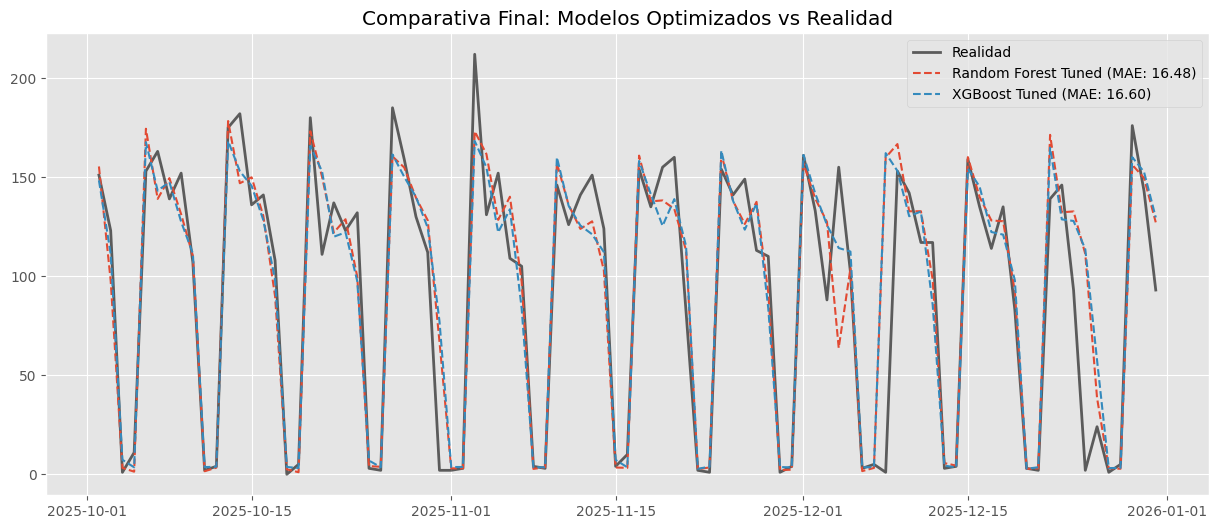

                Modelo  MAE Final  RMSE Final
0  Random Forest Tuned  16.482468   28.596820
1        XGBoost Tuned  16.603222   28.137433


In [ ]:
print(f"Iniciando optimización con {len(X_train)} registros de entrenamiento...")

# A. Validación Cruzada para Series de Tiempo (3 cortes progresivos)
# Corte 1: Entrena Ene-Mar, Valida Abr
# Corte 2: Entrena Ene-Abr, Valida May
# Corte 3: Entrena Ene-May, Valida Jun
tscv = TimeSeriesSplit(n_splits=3)

# B. Definición de Grillas de Hiperparámetros
param_grid_rf = {
    'n_estimators': [200, 300 ,500],        # Número de árboles
    'max_depth': [10, 15, 20, 30, None],       # Profundidad máxima (evitar overfitting)
    'min_samples_split': [2, 5, 10],   # Mínimo para dividir un nodo
    'min_samples_leaf': [1, 2, 4],     # Mínimo en hojas (suavizado)
    'bootstrap': [True]
}

param_grid_xgb = {
    'n_estimators': [200, 300 ,500],
    'learning_rate': [0.01, 0.05, 0.1], # Velocidad de aprendizaje (menor es más preciso pero lento)
    'max_depth': [3, 5, 7, 10],             # Complejidad del árbol
    'subsample': [0.7, 0.9, 1.0],       # % de datos usados por árbol (evita overfitting)
    'colsample_bytree': [0.7, 1.0]      # % de columnas usadas
}

#grid search
modelos_optimizados = {}

#OPTIMIZACIÓN RANDOM FOREST
print("\nOptimizando Random Forest")
start_time = time.time()

rf_base = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
mae_rf = -grid_rf.best_score_

print(f"Mejor RF encontrado en {time.time() - start_time:.1f}s")
print(f"MAE Promedio en Validación: {mae_rf:.2f}")
print(f"Mejores Parámetros: {grid_rf.best_params_}")
modelos_optimizados['Random Forest Tuned'] = best_rf

# OPTIMIZACIÓN XGBOOST
try:
    print("\ Optimizando XGBoost")
    start_time = time.time()
    
    xgb_base = XGBRegressor(random_state=42, n_jobs=1)
    grid_xgb = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_xgb,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_xgb.fit(X_train, y_train)
    best_xgb = grid_xgb.best_estimator_
    mae_xgb = -grid_xgb.best_score_
    
    print(f"Mejor XGBoost encontrado en {time.time() - start_time:.1f}s")
    print(f"MAE Promedio en Validación: {mae_xgb:.2f}")
    print(f"Mejores Parámetros: {grid_xgb.best_params_}")
    modelos_optimizados['XGBoost Tuned'] = best_xgb

except ImportError:
    print("\n XGBoost no instalado. Saltando optimización.")

#EVALUACIÓN FINAL
print("\nRESULTADOS FINALES EN TEST (Datos nunca vistos)")
resultados_finales = []

#plot
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Realidad', color='black', linewidth=2, alpha=0.6)

for nombre, modelo in modelos_optimizados.items():
    preds = modelo.predict(X_test)
    mae_test = mean_absolute_error(y_test, preds)
    rmse_test = np.sqrt(mean_squared_error(y_test, preds))
    
    resultados_finales.append({'Modelo': nombre, 'MAE Final': mae_test, 'RMSE Final': rmse_test})
    
    plt.plot(test.index, preds, label=f'{nombre} (MAE: {mae_test:.2f})', linestyle='--')
    
    # Guardado
    safe_name = nombre.replace(" ", "_").lower()
    path_model = f'../models/{safe_name}.pkl'
    joblib.dump(modelo, path_model)
    print(f" Modelo guardado: {path_model}")

plt.title('Comparativa Final: Modelos Optimizados vs Realidad')
plt.legend()
plt.show()

# Tabla final
print(pd.DataFrame(resultados_finales).sort_values('MAE Final'))

12:19:49 - cmdstanpy - INFO - Chain [1] start processing
12:19:49 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
MAE:  13.51
RMSE: 21.52


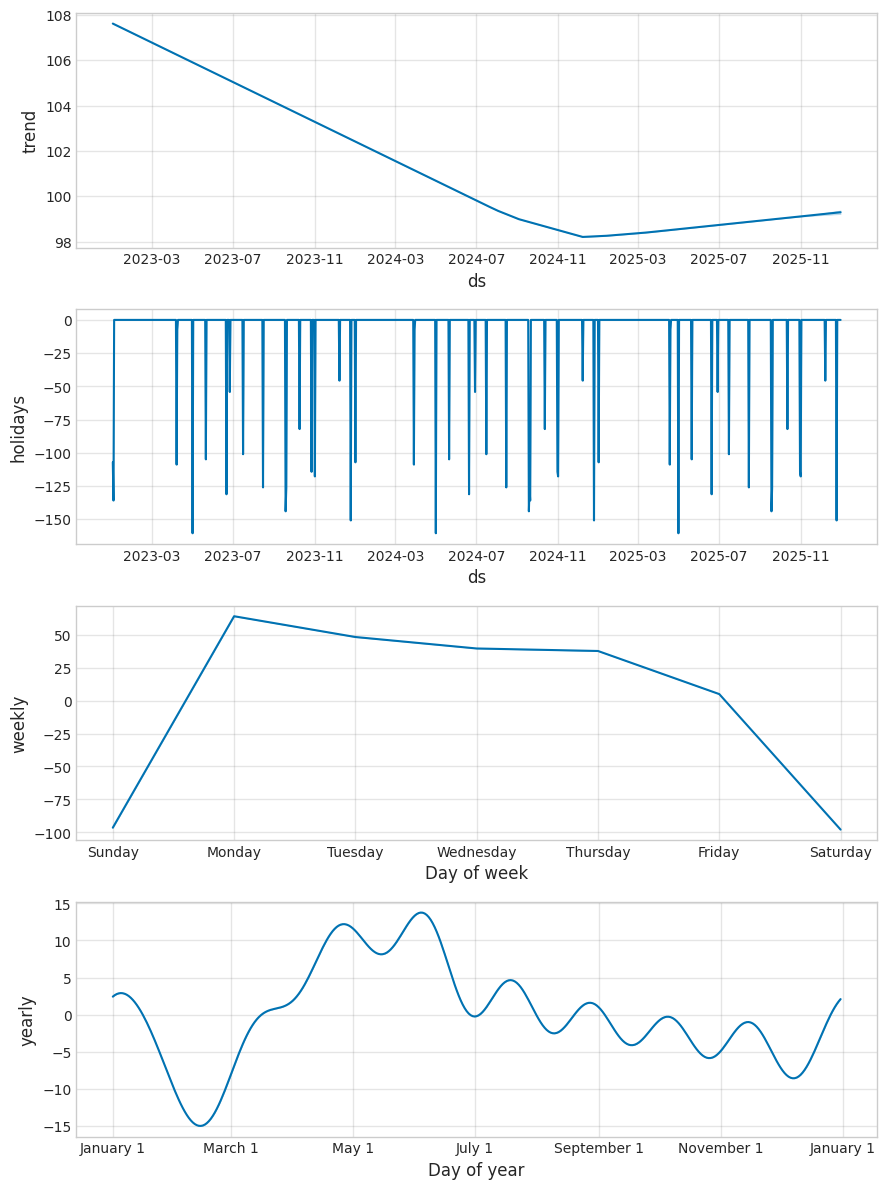

In [19]:
#Codigo Prophet de meta

# Preparar formato (ds=fecha, y=valor)
df_prophet = ts_diaria.reset_index().rename(columns={'fecha_de_apertura': 'ds', 'cantidad_tickets': 'y'})

# train / test
corte = df_prophet['ds'].max() - pd.Timedelta(days=90)
train_p = df_prophet[df_prophet['ds'] < corte]
test_p = df_prophet[df_prophet['ds'] >= corte]

# Configurar Prophet
m = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False)

#feriados por pais 
m.add_country_holidays(country_name='CL') 

#train
m.fit(train_p)

# Predecir
future = m.make_future_dataframe(periods=len(test_p))
forecast = m.predict(future)

# Evaluar
predicciones_prophet = forecast.tail(len(test_p))['yhat'].values
y_true = test_p['y'].values

# evitar predicciones negativas
predicciones_prophet = np.maximum(predicciones_prophet, 0)

#metricas
mae_p = mean_absolute_error(y_true, predicciones_prophet)
rmse_p = np.sqrt(mean_squared_error(y_true, predicciones_prophet))

print(f"\nProphet Performance:")
print(f"MAE:  {mae_p:.2f}")
print(f"RMSE: {rmse_p:.2f}")

# gráficos de "Qué pasa los lunes" o "Qué pasa en Diciembre"
fig = m.plot_components(forecast)
plt.show()

In [20]:
#guardar mejor modelo
joblib.dump(m, '../models/prophet.pkl')

['../models/prophet.pkl']

In [21]:
#Prediccion de areas basada en palabras claves con PNL
def reparar_texto_interno(texto):
    if not isinstance(texto, str): return texto
    reemplazos = {
        'Ã³': 'ó', 'Ã¡': 'á', 'Ã©': 'é', 'Ã\xad': 'í', 'Ã': 'í',
        'Ã±': 'ñ', 'Ãº': 'ú', 'Ã\x81': 'Á', 'Ã\x89': 'É',
        'Ã\x8d': 'Í', 'Ã\x93': 'Ó', 'Ã\x9a': 'Ú', 'Ã\x91': 'Ñ',
        'â\x80\x93': '-', 'â\x80\x9c': '"', 'â\x80\x9d': '"'
    }
    for mal, bien in reemplazos.items():
        if mal in texto: texto = texto.replace(mal, bien)
    return texto.strip()

if 'area' not in df_all.columns:
    print("Generando columna 'area' desde 'categoria'")
    
    if 'categoria' in df_all.columns:
        series_cat = df_all['categoria'].fillna('Sin Categoria').astype(str)
        
        df_all['area'] = series_cat.apply(lambda x: x.split('>')[0].strip() if '>' in x else x.strip())
        df_all['area'] = df_all['area'].apply(reparar_texto_interno)
        
    else:
        print("Error: No se encontró la columna 'categoria'. Se asignará 'Desconocido'.")
        df_all['area'] = 'Desconocido'

Analizando 35784 tickets de Infraestructura
Aplicando limpieza avanzada (Normalizando 'querie' -> 'query', etc)


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



NUEVOS TEMAS DETECTADOS (LIMPIOS)

CLUSTER 0: ACCESO, CUENTA, VPN, CAMBIARCLAVESAP, PROBLEMAS, FUENTES
   VOLUMEN: 13529 | Tiempo Mediana: 61.1 h
   EJEMPLOS: ['re glpi 0215209 re re cambio de ip vpn 1055', 're cambiarclavesap francisca tatiana alcazar barrios 416', 'habilitación vpn cuentas usuarios cyr 418']

CLUSTER 1: CLAVE, SAP, CLAVE SAP, CAMBIO CLAVE, CAMBIO CLAVE SAP, CAMBIO
   VOLUMEN: 2135 | Tiempo Mediana: 53.0 h
   EJEMPLOS: ['rv cambio clave sap 444', 'bloqueo clave sap 500', 'bloqueo clave sap 560']

CLUSTER 2: DBA, SCRIPT, DBA SCRIPT, FACTURACION, HOY, FACTURACION HOY
   VOLUMEN: 10187 | Tiempo Mediana: 61.0 h
   EJEMPLOS: ['dba validación de logins consultores sap 515', 're dba validación de logins consultores sap 654', 're dba error de espacio en bd inter3 757']

CLUSTER 3: SQL, SCRIPT, SQL SCRIPT, EJECUCIN, CASO, ESPECIAL
   VOLUMEN: 6985 | Tiempo Mediana: 0.2 h
   EJEMPLOS: ['rv amb sql sfpa07081 1153', 're sql developer 3338', 'clave sql bloqueada 3968']

CLUSTER 4

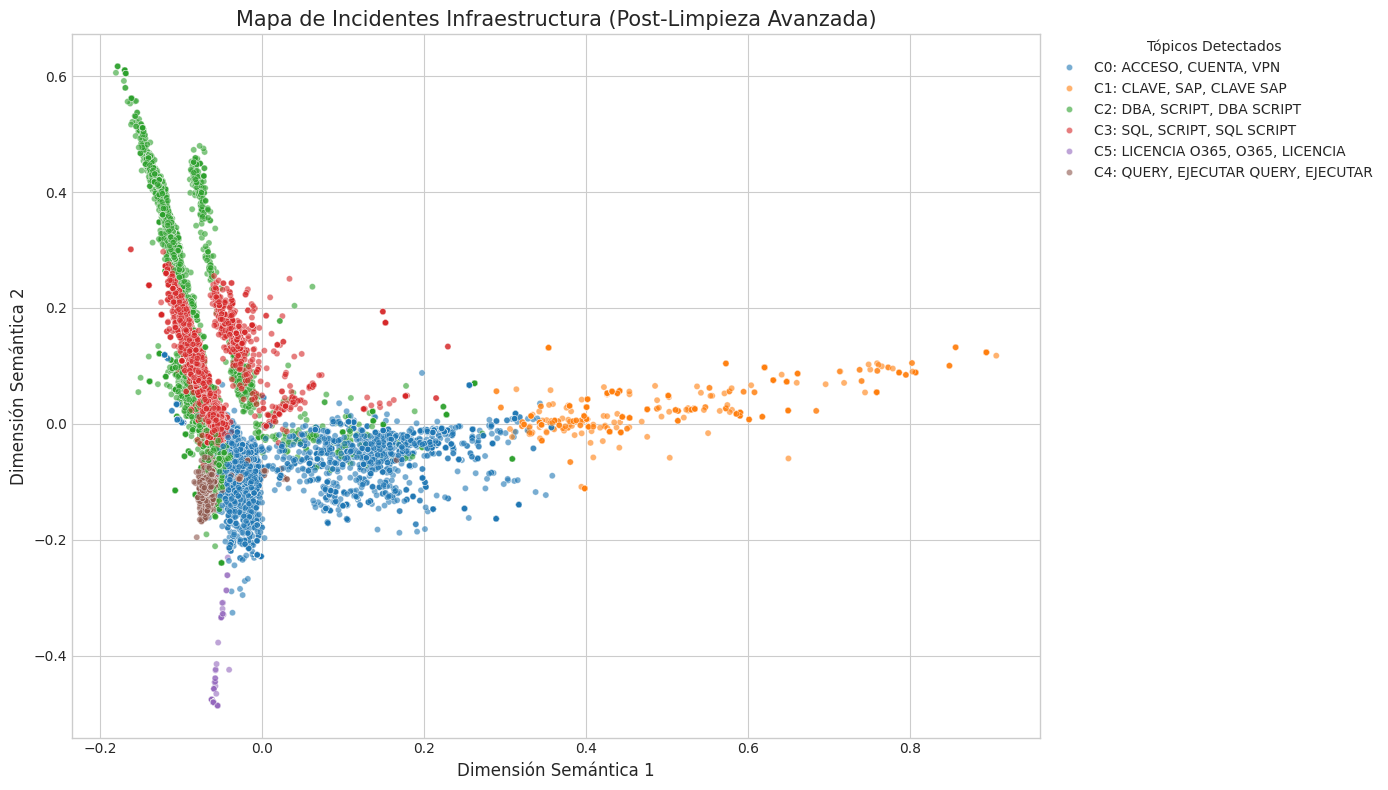

/tmp/ipykernel_301891/3156204098.py:190: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


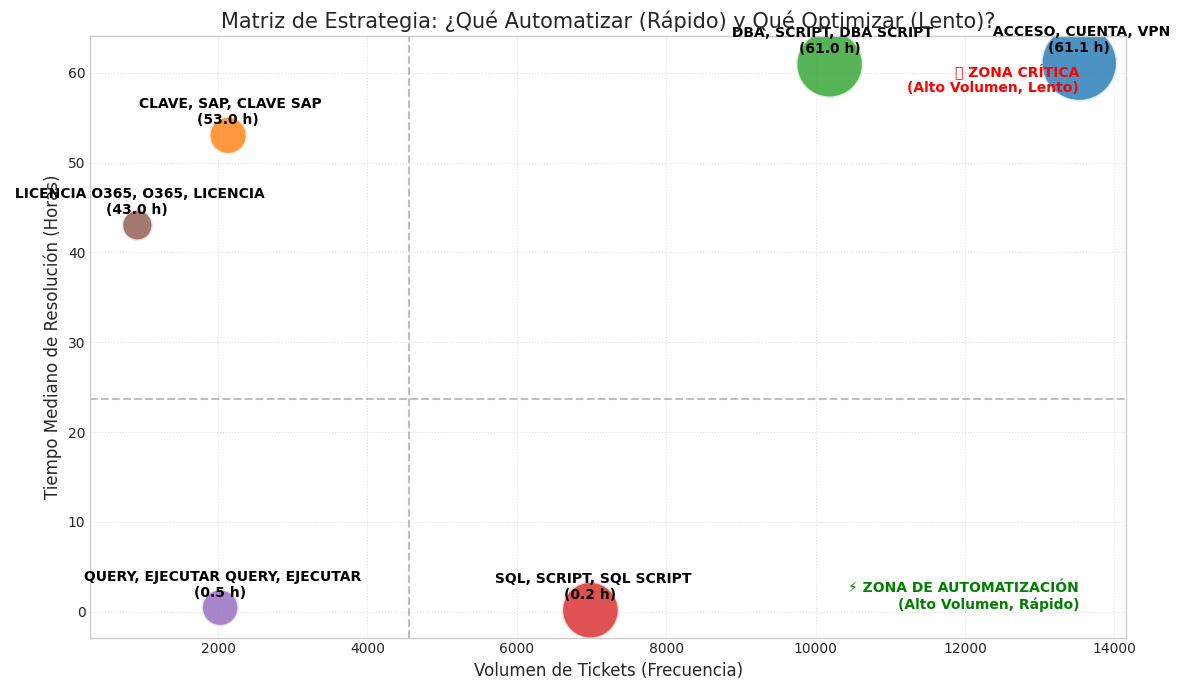

/tmp/ipykernel_301891/3156204098.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/3156204098.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/3156204098.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/3156204098.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

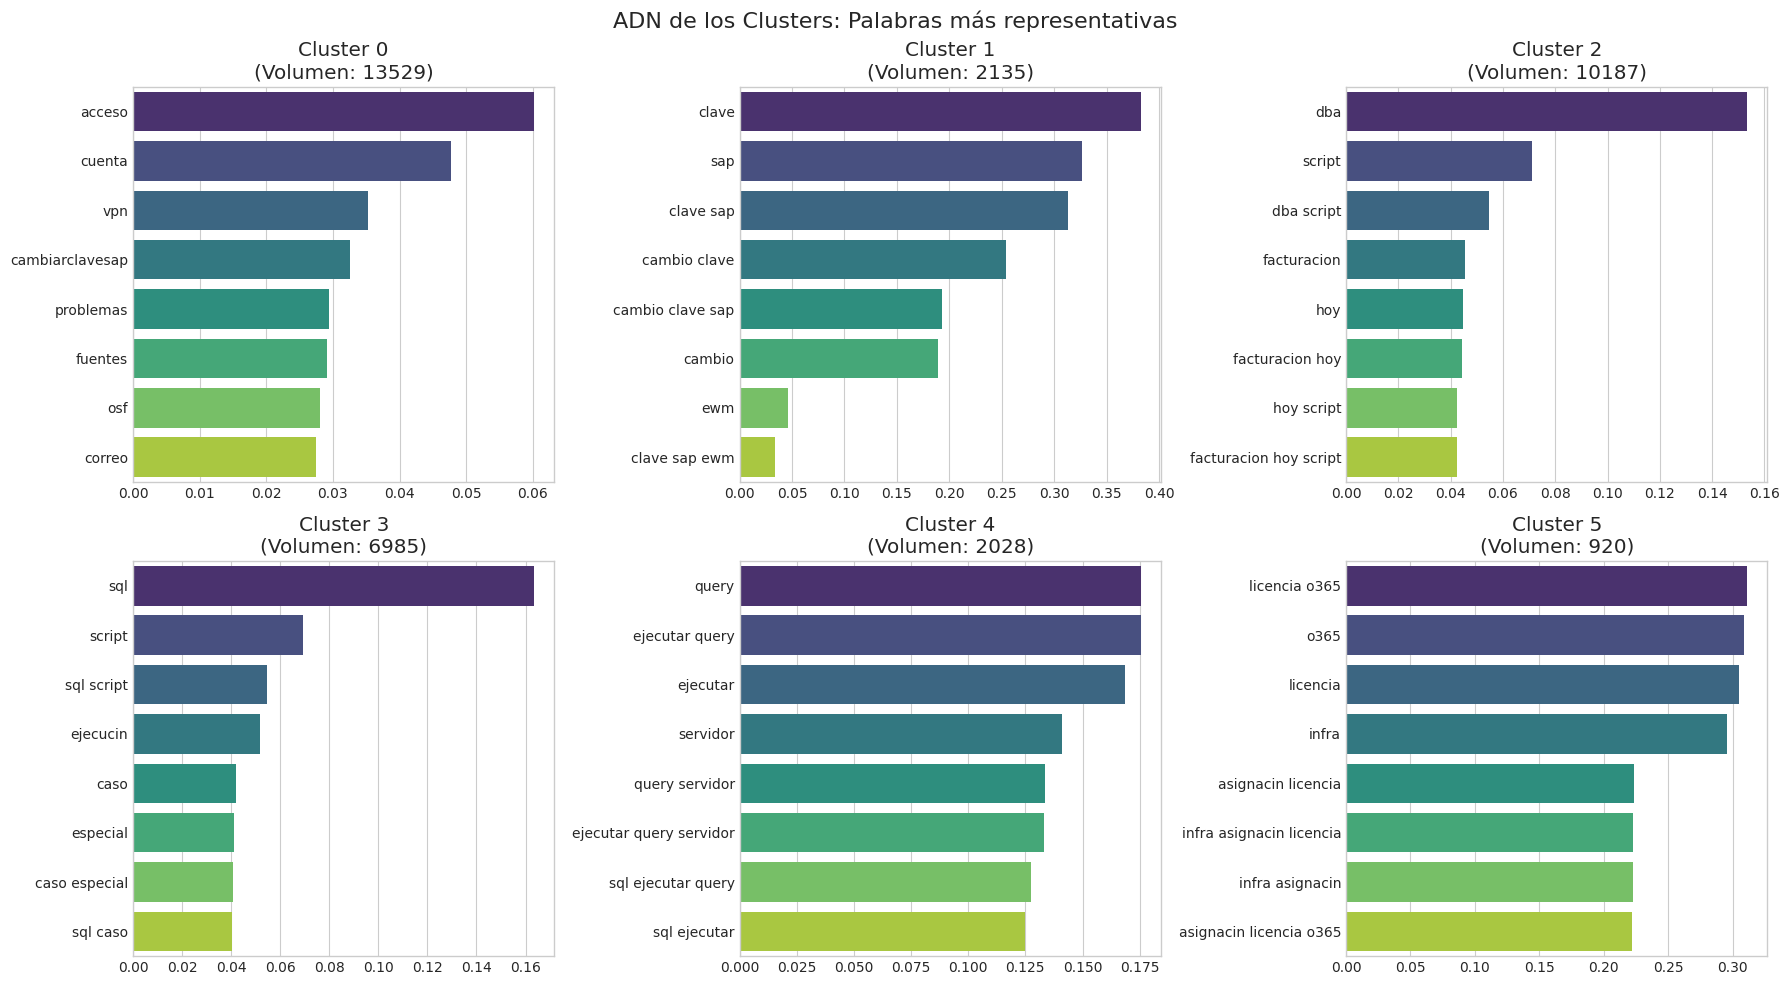

In [23]:

#Analisis de PNL completo y visualizacion
target_areas = ['DBA', 'Ingenieros TI', 'Técnico TI', 'Tecnico TI']

if 'area' not in df_all.columns:
    df_all['area'] = df_all['categoria'].fillna('').apply(lambda x: x.split('>')[0].strip())

df_nlp = df_all[df_all['area'].isin(target_areas)].copy()

print(f"Analizando {len(df_nlp)} tickets de Infraestructura")

#correcciones comunes vistas
correcciones = {
    r'\bquerie\b': 'query',       
    r'\bqueries\b': 'query',      
    r'\bquerys\b': 'query',
    r'\bquery\b': 'query',
    
    # Palabras pegadas
    r'cambioclavesap': 'cambio clave sap', 
    r'cambioclave': 'cambio clave',
    r'ejecutarscript': 'ejecutar script',
    
    # Sinónimos de Negocio
    r'\bpass\b': 'clave',
    r'\bpassword\b': 'clave',
    r'\bcontraseña\b': 'clave',
    r'\breset\b': 'cambio',
    r'\bdesbloqueo\b': 'cambio',
    r'\bgenerar\b': 'crear',
    r'\balta\b': 'crear',
    
    # Sistemas
    r'\bbdd\b': 'bd',
    r'\bbase de datos\b': 'bd',
    r'\bsql server\b': 'sql',
    r'\bsap hana\b': 'sap'
}

def limpiar_titulo_avanzado(texto):
    if not isinstance(texto, str): return ""
    
    texto = texto.lower()
    
    # Aplicar correcciones 
    for error, correccion in correcciones.items():
        texto = re.sub(error, correccion, texto)
    
    texto = re.sub(r'[^a-záéíóúñ0-9 ]', '', texto) 
    
    # Quitar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# aplicar limpieza
print("Aplicando limpieza avanzada (Normalizando 'querie' -> 'query', etc)")
df_nlp['titulo_limpio'] = df_nlp['titulo'].apply(limpiar_titulo_avanzado)

# vectorizacion (TF-IDF)
nltk.download('stopwords')
stop_words = stopwords.words('spanish')
basura = ['ticket', 'solicitud', 'favor', 're', 'rv', 'fwd', 'hola', 'estimados', 
          'dia', 'tarde', 'aviso', 'notificacion', 'urgente', 'incidencia', 
          'problema', 'error', 'apoyo', 'realizar', 'solicito', 'generado', 'automaticamente']
stop_words.extend(basura)

vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    max_features=1000,
    ngram_range=(1, 3),
    min_df=5 
)

X_matrix = vectorizer.fit_transform(df_nlp['titulo_limpio'])

# Clustering (K-Means)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_matrix)
df_nlp['cluster'] = kmeans.labels_

print("\nNUEVOS TEMAS DETECTADOS (LIMPIOS)")
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :6]]
    
    # Calculamos métricas para ver el impacto
    stats = df_nlp[df_nlp['cluster'] == i]['tiempo_vida_horas']
    count = len(stats)
    mediana = stats.median()
    
    print(f"\nCLUSTER {i}: {', '.join(top_terms).upper()}")
    print(f"   VOLUMEN: {count} | Tiempo Mediana: {mediana:.1f} h")
    print(f"   EJEMPLOS: {df_nlp[df_nlp['cluster'] == i]['titulo_limpio'].head(3).tolist()}")

#Visualizacion

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

#preparacion de etiquetas (nombres legibles para los clusters basados en sus top 3 palabras)
print("Generando etiquetas para los gráficos")
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_labels = {}

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :3]]
    # Ejemplo: "C0: ACCESO, VPN, CUENTA"
    cluster_labels[i] = f"C{i}: {', '.join(top_terms).upper()}"

df_nlp['Label_Cluster'] = df_nlp['cluster'].map(cluster_labels)

#grafico 1 de mapa semantico 2D
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_matrix.toarray())

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x=coords[:, 0], 
    y=coords[:, 1], 
    hue=df_nlp['Label_Cluster'], 
    palette='tab10', 
    alpha=0.6, 
    s=20
)

# Centrar el mapa y poner leyenda fuera
plt.title('Mapa de Incidentes Infraestructura (Post-Limpieza Avanzada)', fontsize=15)
plt.xlabel('Dimensión Semántica 1')
plt.ylabel('Dimensión Semántica 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Tópicos Detectados")
plt.tight_layout()
plt.show()

# grafico 2 MATRIZ DE DECISIÓN (VOLUMEN VS TIEMPO)
# Agrupacion para ver el impacto de negocio
stats = df_nlp.groupby('Label_Cluster').agg({
    'id': 'count',
    'tiempo_vida_horas': 'median'
}).reset_index()

plt.figure(figsize=(12, 7))
#tamaño de burbuja para ver el tamaño
bubble = sns.scatterplot(
    data=stats, 
    x='id', 
    y='tiempo_vida_horas', 
    size='id', 
    sizes=(500, 3000), 
    hue='Label_Cluster', 
    palette='tab10', 
    legend=False,
    alpha=0.8
)

# Etiquetas
for i in range(stats.shape[0]):
    x_pos = stats.id[i]
    y_pos = stats.tiempo_vida_horas[i]
    label = stats.Label_Cluster[i].split(':')[1]
    
    plt.text(x_pos, y_pos + (stats.tiempo_vida_horas.max()*0.02), 
             f"{label}\n({stats.tiempo_vida_horas[i]:.1f} h)", 
             horizontalalignment='center', 
             weight='bold', 
             fontsize=10,
             color='black')

# Cuadrantes de Estrategia
mediana_global_tiempo = df_nlp['tiempo_vida_horas'].median()
mediana_global_vol = stats['id'].median()

plt.axhline(mediana_global_tiempo, color='grey', linestyle='--', alpha=0.5)
plt.axvline(mediana_global_vol, color='grey', linestyle='--', alpha=0.5)

plt.title('Matriz de Estrategia: ¿Qué Automatizar (Rápido) y Qué Optimizar (Lento)?', fontsize=15)
plt.xlabel('Volumen de Tickets (Frecuencia)', fontsize=12)
plt.ylabel('Tiempo Mediano de Resolución (Horas)', fontsize=12)

# Anotaciones de Cuadrantes
plt.text(stats['id'].max(), 0, '⚡ ZONA DE AUTOMATIZACIÓN\n(Alto Volumen, Rápido)', 
         ha='right', va='bottom', color='green', fontweight='bold')
plt.text(stats['id'].max(), stats['tiempo_vida_horas'].max(), '🚨 ZONA CRÍTICA\n(Alto Volumen, Lento)', 
         ha='right', va='top', color='red', fontweight='bold')

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

#grafico 3 histograma de palabras claves por cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(k):
    # Top 8 palabras
    top_indices = order_centroids[i, :8]
    top_words = [terms[ind] for ind in top_indices]
    scores = [kmeans.cluster_centers_[i, ind] for ind in top_indices]
    
    sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Cluster {i}\n(Volumen: {len(df_nlp[df_nlp['cluster']==i])})")
    axes[i].set_xlabel('')

plt.suptitle('ADN de los Clusters: Palabras más representativas', fontsize=16)
plt.tight_layout()
plt.show()

Generando etiquetas para los gráficos...


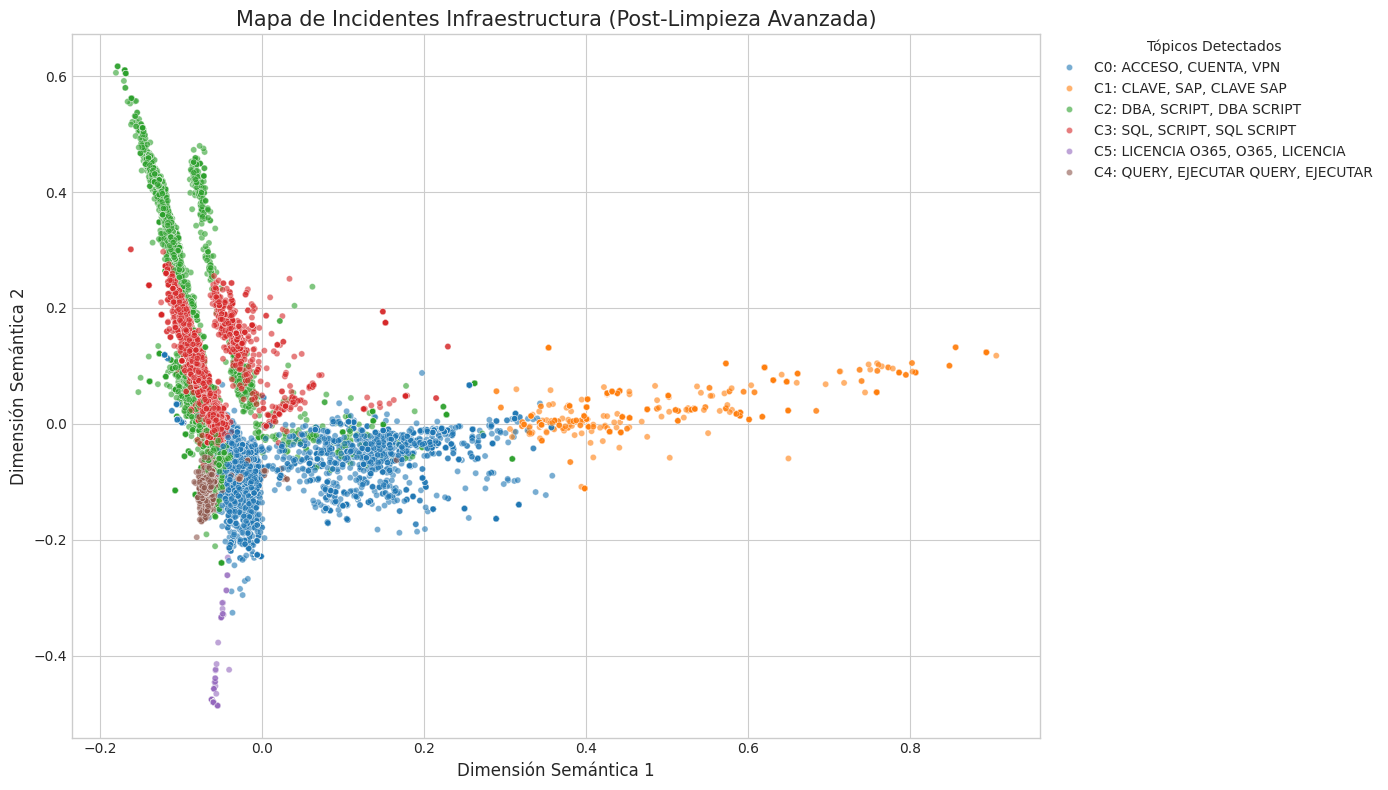

/tmp/ipykernel_301891/377837854.py:95: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


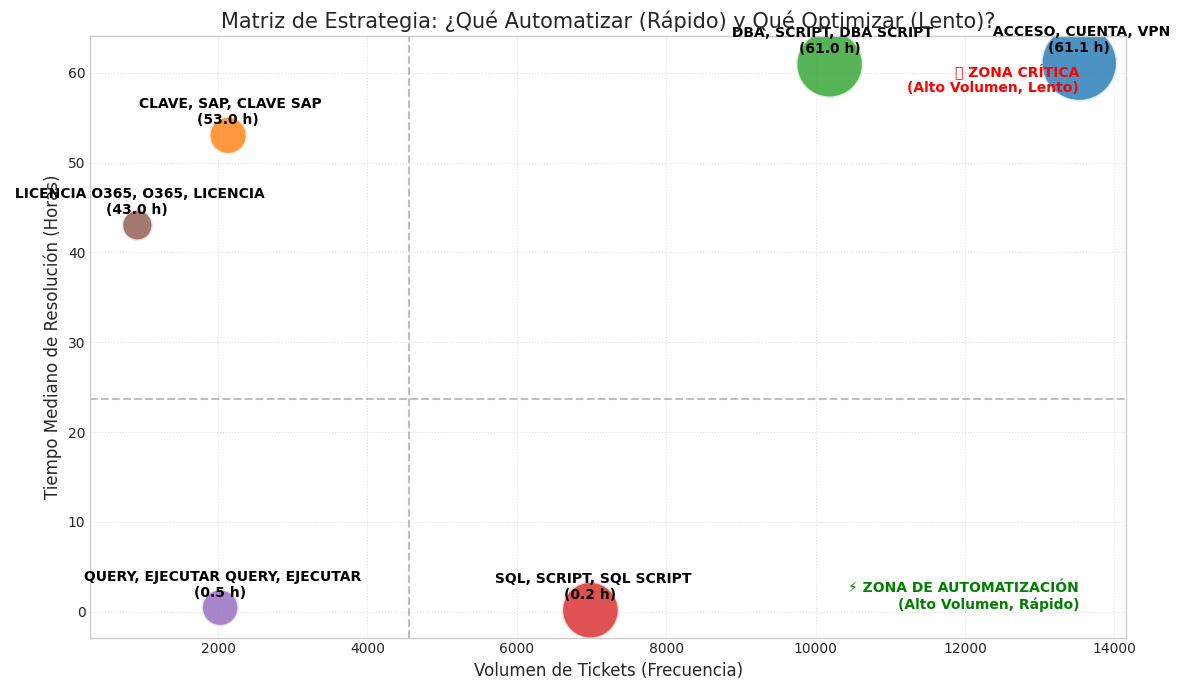

/tmp/ipykernel_301891/377837854.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/377837854.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/377837854.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
/tmp/ipykernel_301891/377837854.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be re

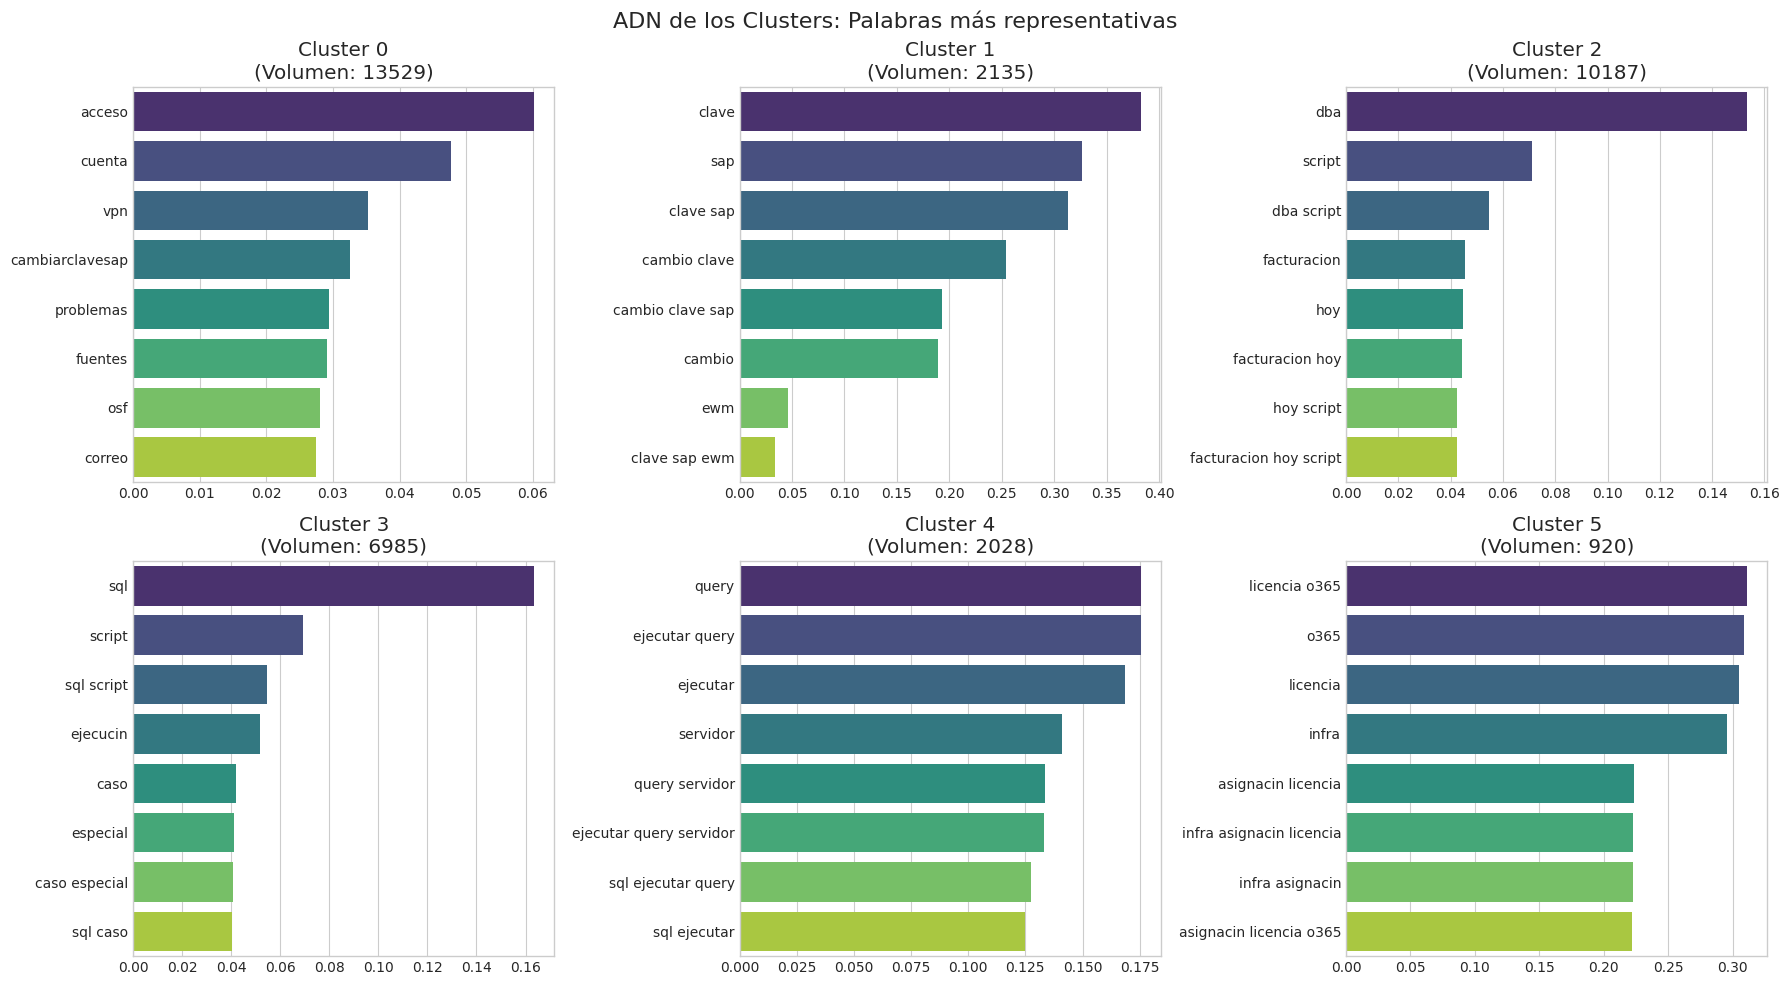

In [24]:

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# --- 1. PREPARACIÓN DE ETIQUETAS DINÁMICAS ---
# Generamos nombres legibles para los clusters basados en sus top 3 palabras
print("Generando etiquetas para los gráficos...")
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_labels = {}

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :3]]
    # Ejemplo: "C0: ACCESO, VPN, CUENTA"
    cluster_labels[i] = f"C{i}: {', '.join(top_terms).upper()}"

df_nlp['Label_Cluster'] = df_nlp['cluster'].map(cluster_labels)

# --- GRÁFICO 1: MAPA SEMÁNTICO (PCA 2D) ---
# Reducimos las 1000 dimensiones del texto a 2 para poder verlas en un plano
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_matrix.toarray())

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x=coords[:, 0], 
    y=coords[:, 1], 
    hue=df_nlp['Label_Cluster'], 
    palette='tab10', 
    alpha=0.6, 
    s=20
)

# Centrar el mapa y poner leyenda fuera
plt.title('Mapa de Incidentes Infraestructura (Post-Limpieza Avanzada)', fontsize=15)
plt.xlabel('Dimensión Semántica 1')
plt.ylabel('Dimensión Semántica 2')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Tópicos Detectados")
plt.tight_layout()
plt.show()

# --- GRÁFICO 2: MATRIZ DE DECISIÓN (VOLUMEN VS TIEMPO) ---
# Agrupamos para ver el impacto de negocio
stats = df_nlp.groupby('Label_Cluster').agg({
    'id': 'count',
    'tiempo_vida_horas': 'median'
}).reset_index()

plt.figure(figsize=(12, 7))
# Usamos el tamaño de la burbuja para reforzar el volumen
bubble = sns.scatterplot(
    data=stats, 
    x='id', 
    y='tiempo_vida_horas', 
    size='id', 
    sizes=(500, 3000), 
    hue='Label_Cluster', 
    palette='tab10', 
    legend=False,
    alpha=0.8
)

# Etiquetas inteligentes en el gráfico
for i in range(stats.shape[0]):
    # Ajuste de posición para que el texto no tape el punto
    x_pos = stats.id[i]
    y_pos = stats.tiempo_vida_horas[i]
    label = stats.Label_Cluster[i].split(':')[1] # Solo las palabras clave
    
    plt.text(x_pos, y_pos + (stats.tiempo_vida_horas.max()*0.02), 
             f"{label}\n({stats.tiempo_vida_horas[i]:.1f} h)", 
             horizontalalignment='center', 
             weight='bold', 
             fontsize=10,
             color='black')

# Cuadrantes de Estrategia
mediana_global_tiempo = df_nlp['tiempo_vida_horas'].median()
mediana_global_vol = stats['id'].median()

plt.axhline(mediana_global_tiempo, color='grey', linestyle='--', alpha=0.5)
plt.axvline(mediana_global_vol, color='grey', linestyle='--', alpha=0.5)

plt.title('Matriz de Estrategia: ¿Qué Automatizar (Rápido) y Qué Optimizar (Lento)?', fontsize=15)
plt.xlabel('Volumen de Tickets (Frecuencia)', fontsize=12)
plt.ylabel('Tiempo Mediano de Resolución (Horas)', fontsize=12)

# Anotaciones de Cuadrantes
plt.text(stats['id'].max(), 0, '⚡ ZONA DE AUTOMATIZACIÓN\n(Alto Volumen, Rápido)', 
         ha='right', va='bottom', color='green', fontweight='bold')
plt.text(stats['id'].max(), stats['tiempo_vida_horas'].max(), '🚨 ZONA CRÍTICA\n(Alto Volumen, Lento)', 
         ha='right', va='top', color='red', fontweight='bold')

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

#grafico 3 histograma de palabras claves por cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(k):
    # Top 8 palabras
    top_indices = order_centroids[i, :8]
    top_words = [terms[ind] for ind in top_indices]
    scores = [kmeans.cluster_centers_[i, ind] for ind in top_indices]
    
    sns.barplot(x=scores, y=top_words, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Cluster {i}\n(Volumen: {len(df_nlp[df_nlp['cluster']==i])})")
    axes[i].set_xlabel('')

plt.suptitle('ADN de los Clusters: Palabras más representativas', fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_301891/1184762355.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumen_estrategia, x='Estrategia', y='Tiempo_Horas', ax=axes[1], palette='viridis')
/tmp/ipykernel_301891/1184762355.py:35: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_301891/1184762355.py:35: UserWarning: Glyph 128736 (\N{HAMMER AND WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_301891/1184762355.py:35: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/projec

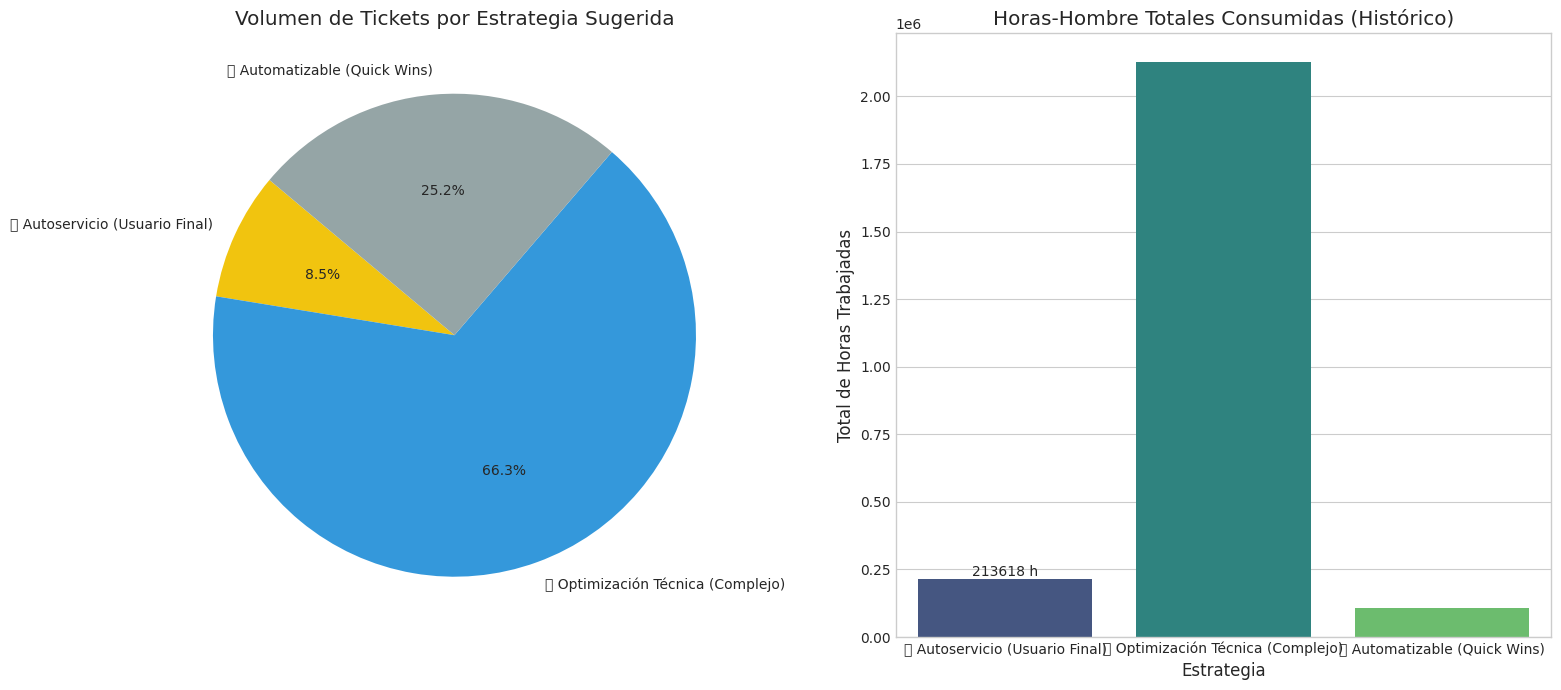

In [ ]:
# Mapeo manual basado en los clusters

#clasificar tareas de cluster
def clasificar_oportunidad(cluster_id):
    if cluster_id in [3, 4]: 
        return "🤖 Automatizable (Quick Wins)"
    elif cluster_id in [1, 5]:
        return "🔑 Autoservicio (Usuario Final)"
    else:
        return "🛠️ Optimización Técnica (Complejo)"

df_nlp['Estrategia'] = df_nlp['cluster'].apply(clasificar_oportunidad)

# Agrupamos
resumen_estrategia = df_nlp.groupby('Estrategia').agg(
    Volumen=('id', 'count'),
    Tiempo_Horas=('tiempo_vida_horas', 'sum') # total de horas consumidas históricamente
).reset_index()

# Gráfico de Pastel
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Cuántos tickets nos quitariamos de encima?
axes[0].pie(resumen_estrategia['Volumen'], labels=resumen_estrategia['Estrategia'], 
            autopct='%1.1f%%', colors=['#f1c40f', '#3498db', '#95a5a6'], startangle=140)
axes[0].set_title('Volumen de Tickets por Estrategia Sugerida')

# Cuantas horas hombre ahorrarios?
sns.barplot(data=resumen_estrategia, x='Estrategia', y='Tiempo_Horas', ax=axes[1], palette='viridis')
axes[1].set_title('Horas-Hombre Totales Consumidas (Histórico)')
axes[1].set_ylabel('Total de Horas Trabajadas')
axes[1].bar_label(axes[1].containers[0], fmt='%.0f h')

plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

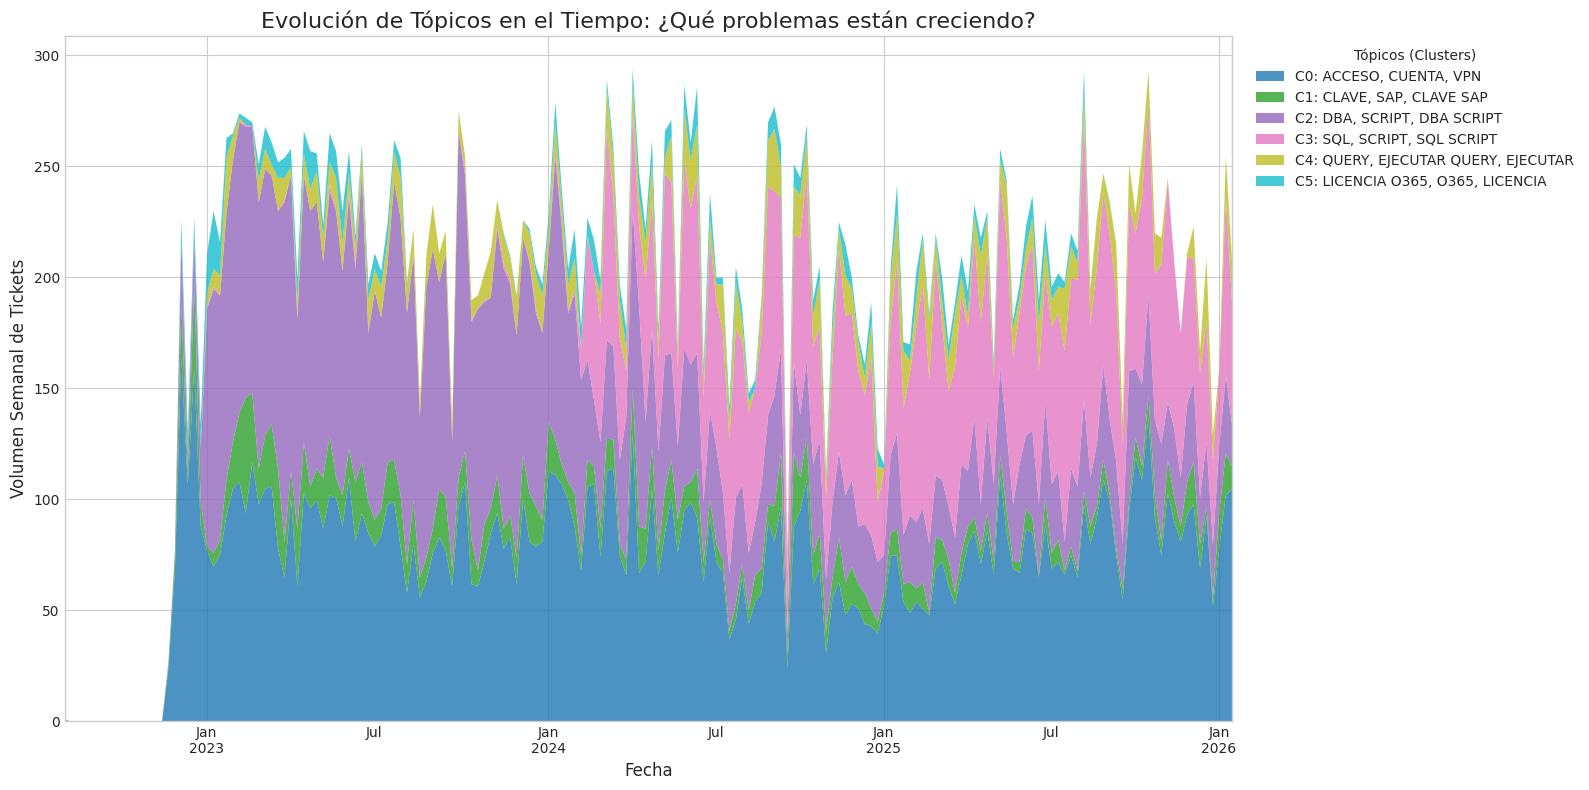

In [26]:
#Evolucion historica de los topicos
if 'fecha_de_apertura' not in df_nlp.columns:
    if df_nlp.index.name == 'fecha_de_apertura':
        df_nlp = df_nlp.reset_index()
    else:
        df_nlp = df_nlp.reset_index().rename(columns={'index': 'fecha_de_apertura'})


# Preparacion de datos
df_mix = df_nlp[['fecha_de_apertura', 'cluster', 'Label_Cluster']].copy()
df_mix['fecha_de_apertura'] = pd.to_datetime(df_mix['fecha_de_apertura'])

#agrupacion mensual
df_pivot = df_mix.pivot_table(
    index='fecha_de_apertura', 
    columns='Label_Cluster', 
    values='cluster', 
    aggfunc='count'
).resample('W').sum().fillna(0)

df_pivot = df_pivot.iloc[:-1] 

# grafico de area apilada
plt.figure(figsize=(16, 8))
df_pivot.plot(kind='area', stacked=True, cmap='tab10', alpha=0.8, linewidth=0, figsize=(16, 8))

plt.title('Evolución de Tópicos en el Tiempo: ¿Qué problemas están creciendo?', fontsize=16)
plt.ylabel('Volumen Semanal de Tickets')
plt.xlabel('Fecha')
plt.legend(title='Tópicos (Clusters)', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\E'
<>:3: SyntaxWarning: invalid escape sequence '\E'
/tmp/ipykernel_301891/1295083849.py:3: SyntaxWarning: invalid escape sequence '\E'
  print(f"\Entrenando oráculo para: {nombre_cluster}...")


\Entrenando oráculo para: C0: ACCESO / VPN / CLAVES...


12:27:08 - cmdstanpy - INFO - Chain [1] start processing
12:27:09 - cmdstanpy - INFO - Chain [1] done processing


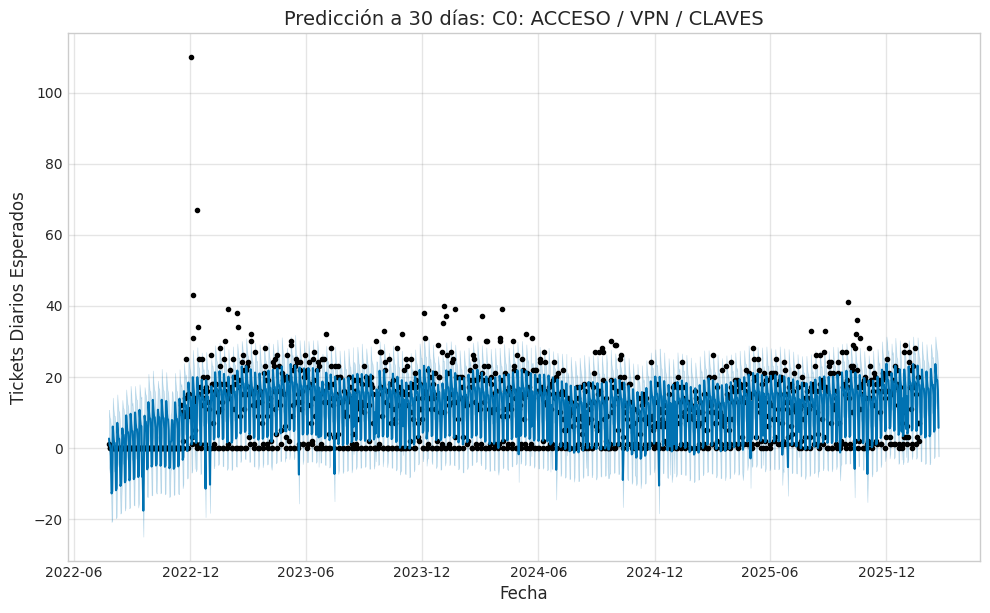

12:27:09 - cmdstanpy - INFO - Chain [1] start processing


   --> Se esperan aprox. 109 tickets de 'C0: ACCESO / VPN / CLAVES' la próxima semana.
\Entrenando oráculo para: C3: SQL / SCRIPTS...


12:27:09 - cmdstanpy - INFO - Chain [1] done processing


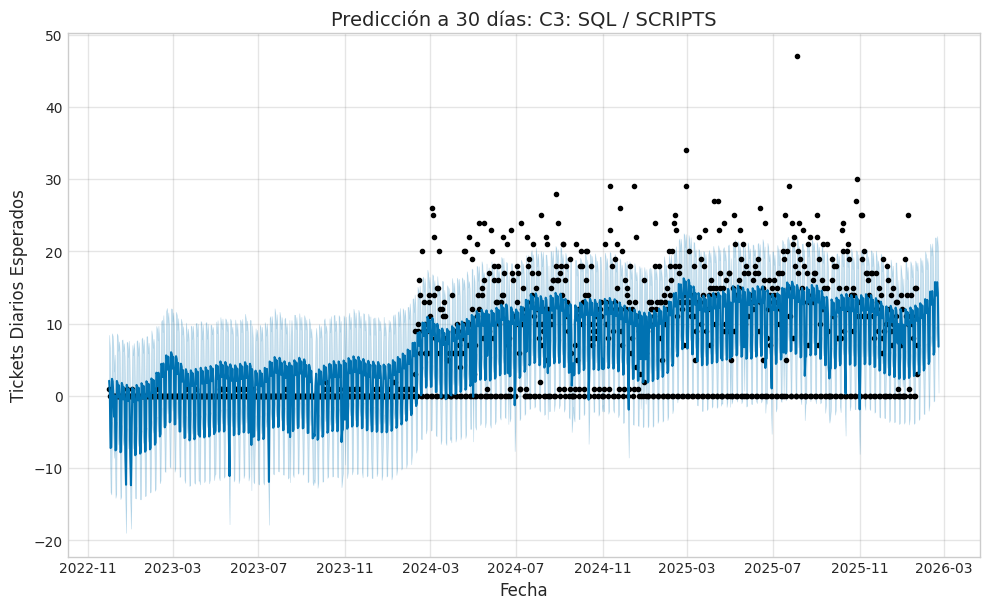

   --> Se esperan aprox. 88 tickets de 'C3: SQL / SCRIPTS' la próxima semana.


In [27]:
#probar prediccion de cantidad con mejor modelo (prophet) y que tipo de tickets
def predecir_cluster(cluster_id, nombre_cluster, df_fuente, dias_futuro=30):
    print(f"\Entrenando oráculo para: {nombre_cluster}...")
    
    #  fltrar solo datos de ese cluster
    df_c = df_fuente[df_fuente['cluster'] == cluster_id].copy()
    
    # formato prophet
    df_prophet = df_c.set_index('fecha_de_apertura').resample('D').size().reset_index()
    df_prophet.columns = ['ds', 'y']
    
    # feriados CL
    m = Prophet(daily_seasonality=False, yearly_seasonality=True)
    m.add_country_holidays(country_name='CL')
    m.fit(df_prophet)
    
    # prediccion cantidad
    future = m.make_future_dataframe(periods=dias_futuro)
    forecast = m.predict(future)
    
    # visualizacion
    fig = m.plot(forecast)
    plt.title(f'Predicción a 30 días: {nombre_cluster}', fontsize=14)
    plt.xlabel('Fecha')
    plt.ylabel('Tickets Diarios Esperados')
    plt.show()
    
    # retorno promedio esperado para una semana
    prox_semana = forecast.tail(7)['yhat'].sum()
    print(f"   --> Se esperan aprox. {int(prox_semana)} tickets de '{nombre_cluster}' la próxima semana.")

#Ajustar los cluster
#Cluster Tóxico (Accesos/VPN)
predecir_cluster(0, "C0: ACCESO / VPN / CLAVES", df_nlp)

# Cluster Automatizable (SQL Scripts)
predecir_cluster(3, "C3: SQL / SCRIPTS", df_nlp)